## CNNが学習した内容を可視化する

### 1. CNNの中間層の活性化の可視化
* 目的: CNNの一連の層によって入力がどのように変換されるのかを理解し、CNNの個々のフィルタの意味を把握するため

### 2. CNNのフィルタの可視化
* 目的: CNNの各フィルタが受け入れる視覚パターンや視覚概念がどのようなものであるのかを正確に理解するため

### 3. 画像におけるクラス活性化のヒートマップの可視化
* 目的: 画像のどの部分が特定のクラスに属していると見なされたのかを理解するため。これにより、画像内のオブジェクトを局所化できるようになる。

In [1]:
from keras import models
model = models.load_model('simplest_cnn_model_mini.h5')

Using TensorFlow backend.


### 1. CNNの中間層の活性化の可視化
* 目的: CNNの一連の層によって入力がどのように変換されるのかを理解し、CNNの個々のフィルタの意味を把握するため

In [2]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [3]:
import os
base_dir = "mini_pictures"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")

Audi_a3_dir = os.path.join(test_dir,"Audi-a3")
fnames = [os.path.join(Audi_a3_dir,fname) for fname in os.listdir(Audi_a3_dir)]

img_path = fnames[3]
print(img_path)

mini_pictures\test\Audi-a3\Audi-a3_5ee6ce7e5db6_11.jpg


(1, 150, 150, 3)


<function matplotlib.pyplot.show(*args, **kw)>

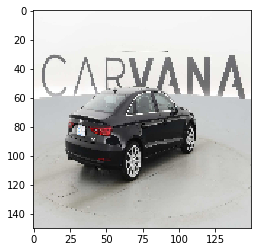

In [9]:
from keras.preprocessing import image
import numpy as np
%matplotlib inline

input_size = 256

img = image.load_img(img_path, target_size=(input_size,input_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor /= 255.
print(img_tensor.shape)
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show

### 入力テンソルと出力テンソルのリストに基づいてモデルをインスタンス化

In [10]:
# 出力側の８つの層から出力を抽出
layer_outputs = [layer.output for layer in model.layers[:8]]

#　特定の入力をもとに、これらの出力を返すモデルを作成
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### モデルを予測モードで実行

In [19]:
# 5つのNumpy配列（層の活性化ごとに１つ）のリストを返す
activations = activation_model.predict(img_tensor)
print(len(activations))

8


### 3番目のチャネルを可視化

(1, 148, 148, 32)


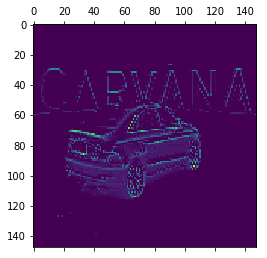

In [13]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0,:,:,3], cmap="viridis")
plt.show()

この写真よりこのチャネルがエンコードしているのは、対角エッジ検出器と考えられる。

### 24番目のチャネルを可視化

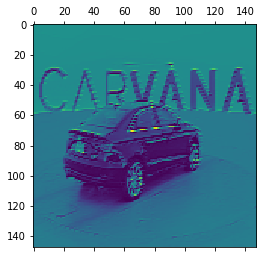

In [27]:
plt.matshow(first_layer_activation[0,:,:,24], cmap='viridis')
plt.show()

上のチャネルはフレームの検出器になっている

### 全ての中間層の活性化マップごとに全てのチャネルを抽出してプロットする。

n_features : 32 (1, 148, 148, 32)
n_features : 32 (1, 74, 74, 32)
n_features : 64 (1, 72, 72, 64)
n_features : 64 (1, 36, 36, 64)
n_features : 128 (1, 34, 34, 128)
n_features : 128 (1, 17, 17, 128)


C:\Users\ibuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


n_features : 128 (1, 15, 15, 128)
n_features : 128 (1, 7, 7, 128)


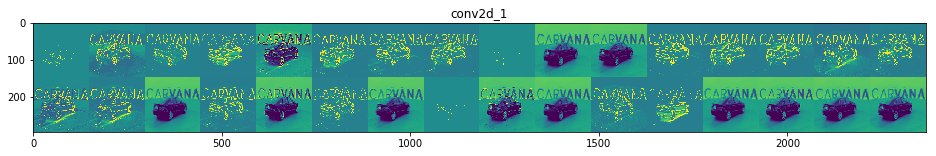

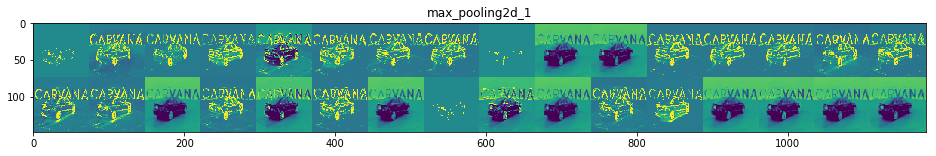

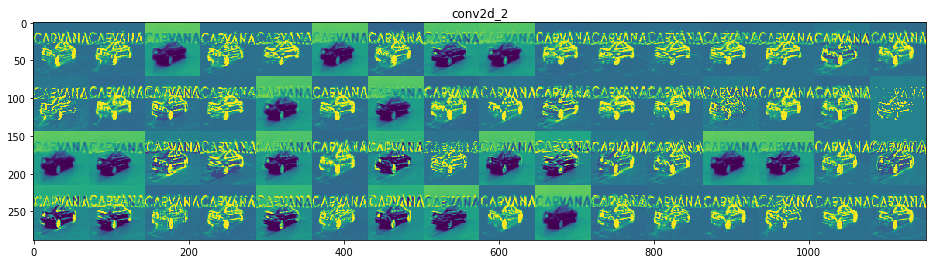

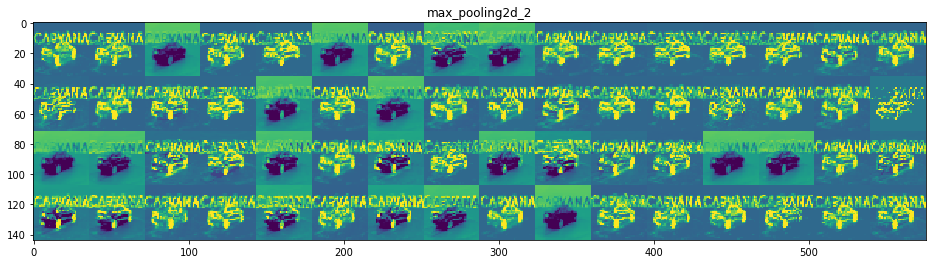

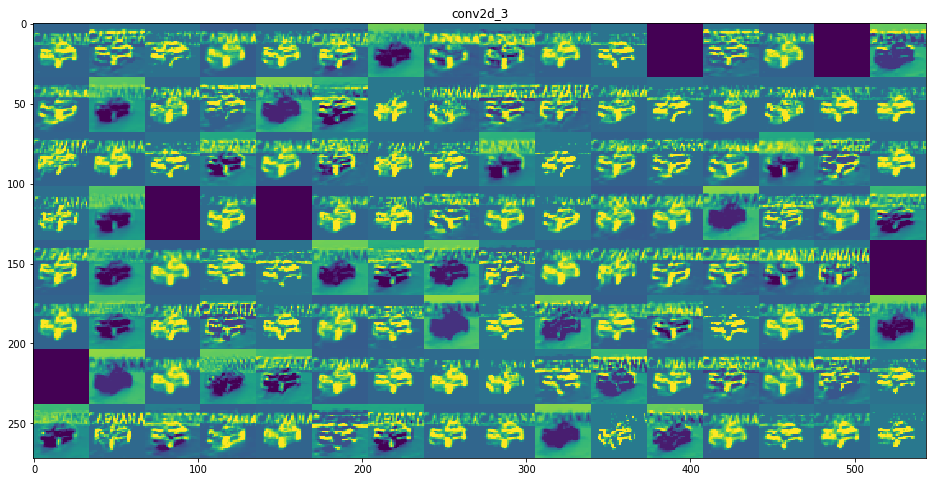

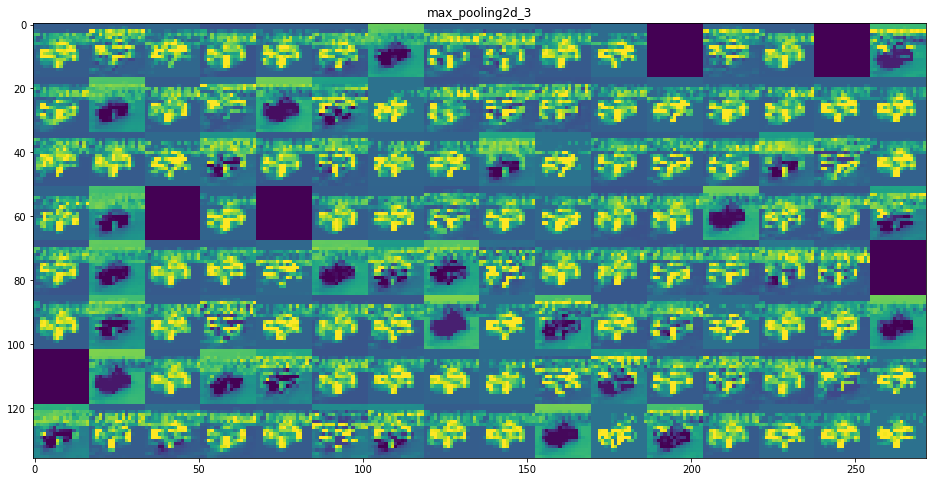

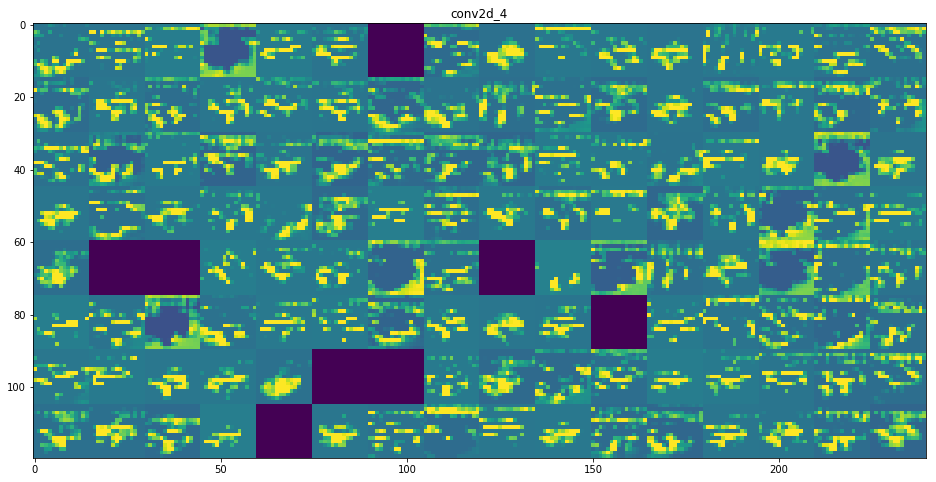

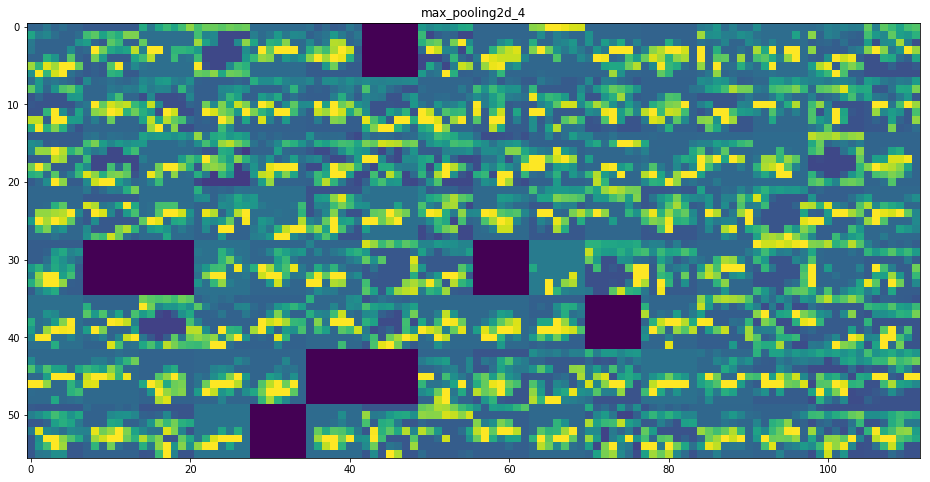

In [25]:
# プロットの一部として使用する層の名前
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

# 特徴マップを表示
for layer_name, layer_activation in zip(layer_names, activations):
    # 特徴マップに含まれている特徴量の数
    n_features = layer_activation.shape[-1]
    print("n_features :",n_features,layer_activation.shape)
    
    # 特徴マップの形状(1, size, size, n_features)
    size = layer_activation.shape[1]
    
    # この行列で活性化チャネルのタイルを表示
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    # 各フィルタを１つの大きな水平グリッドでタイル表示
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            # 特徴量の見た目を良くするための後処理
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:((row+1)*size) ] = channel_image
            
    # グリッドを表示
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
                   
plt.show()

### 分かること

* 最初の層は様々なエッジ検出のコレクションの役割を果たす。この段階では、元の画像に存在している情報はほぼ全てが活性化に含まれている。
* 層から層に進むにつれて、活性化は徐々に抽象化されていくので、視覚的な解釈可能性は低下している。つまりAuid-a3らしさや、BMW-x3らしさなどをエンコードするようになる。
* 活性化の疎性は、層が深くなるほど高くなる。つまり、最初の層では全ての画像が入力画像によって活性化されるが、その後の層では空のフィルタが増えていく。フィルタが空であることはそのフィルタにエンコードされているパターンが入力画像から検出されないことを意味している。（0に近ければ近いほど黒っぽい画像になる)

### 2. CNNのフィルタの可視化
* 目的: CNNの各フィルタが受け入れる視覚パターンや視覚概念がどのようなものであるのかを正確に理解するため

VGG16(ImageNet学習済み)を用いる

In [32]:
# フィルタを可視化するための損失テンソルの定義
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [37]:
# 入力に関する損失関数の勾配を取得
# gradientsの呼び出しはテンソル（この場合はサイズ１）のリストを返すので、最初の要素のみを保持する
grads = K.gradients(loss, model.input)[0]

Tensor("gradients_4/block1_conv1_1/convolution_grad/Conv2DBackpropInput:0", shape=(None, None, None, 3), dtype=float32)


### 勾配の正規化
勾配テンソルをそのL2ノルム（テンソルの値の二乗の和の平方根）で割る  
これにより、入力画像に対して実行される更新の大きさが常に同じ範囲に収まる

In [38]:
# 除算の前に1e-5を足すことで0割を回避
grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)

入力画像に基づいて損失テンソルと勾配テンソルの値を計算する方法が必要になる。  
そこで、この計算を行うkerasのバックエンド関数を自作で定義する。  
関数```iterate```は入力としてNumpyテンソル(サイズ１のテンソルのリスト)を受け取り、出力として２つのNumpyテンソル（損失値と勾配値）のリストを返す関数。

In [39]:
# 入力値をnumpy配列で受け取り、出力値をnumpy配列で返す関数の定義
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,input_size,input_size,3))])

### 確率的勾配降下法を用いて損失値を最大化

In [ ]:
# 最初はノイズが含まれたグレースケール画像を使用
input_img_data = np.random.random((1, input_size, input_size, 3)) * 20 + 128

# 勾配上昇法を40ステップ実行
step = 1. #各勾配の更新の大きさ
